# Fitting a bivariate log-Gaussian Cox process to vessel distributions

In [1]:
from itertools import product
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from plotnine import *

## data

In [2]:
data = pd.read_csv('data/paita.csv')

# split into AIS and Satellite
foo = data.groupby('type')
foo1 = foo.get_group('ais')
foo2 = foo.get_group('satellite')

xy1 = foo1[['x_m', 'y_m']].values
xy2 = foo2[['x_m', 'y_m']].values

# region range in meter
height = 10000
width = 10000

# resolution for binning
resolution = 1000

# number of cells 
n_cells_x = int(width/resolution)
n_cells_y = int(height/resolution)

# grid location
grid_x = np.linspace(0, width, n_cells_x + 1)
grid_y = np.linspace(0, height, n_cells_y + 1)

# centroid of each cell
centroid = np.asarray(list(product(grid_x[:-1] + 0.5*resolution, grid_y[:-1] + 0.5*resolution)))

# count the number of vessels per cell
n_vessels1, _, _ = np.histogram2d(xy1[:, 0], xy1[:, 1], [grid_x, grid_y])
n_vessels1 = n_vessels1.ravel().astype(int)

n_vessels2, _, _ = np.histogram2d(xy2[:, 0], xy2[:, 1], [grid_x, grid_y])
n_vessels2 = n_vessels2.ravel().astype(int)

n_vessels = np.stack([n_vessels1, n_vessels2])

## Model

In [3]:
# gaussian processes with mean 0 standard deviation 1
with pm.Model() as mlgcp:
    rho = pm.Uniform("rho", lower=100, upper=2500)
    cov = 1**2 * pm.gp.cov.ExpQuad(2, ls=rho) + pm.gp.cov.WhiteNoise(1e-6)

    gp1 = pm.gp.Latent(cov_func=cov)
    gp2 = pm.gp.Latent(cov_func=cov)

    V1 = gp1.prior("V1", X=centroid)
    V2 = gp2.prior("V2", X=centroid)

# bivariate lgcp
with mlgcp:
    # dependence
    a11 = pm.Exponential('a11', lam=1)
    a22 = pm.Exponential('a22', lam=1)
    a21 = pm.Normal('a21', mu=0, sigma=10)

    # intercept
    mu1 = pm.Normal('mu1', mu=0, sigma=10)
    mu2 = pm.Normal('mu2', mu=0, sigma=10)

    log_intensity1 = mu1 + a11 * V1
    log_intensity2 = mu2 + a21 * V1 + a22 * V2

    intensity1 = pm.Deterministic('intensity1', pm.math.exp(log_intensity1))
    intensity2 = pm.Deterministic('intensity2', pm.math.exp(log_intensity2))

    intensity = pm.math.stack([intensity1, intensity2])

    y = pm.Poisson("y", mu=intensity, observed=n_vessels)

## Run

In [11]:
with mlgcp:
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.95, chains=2, return_inferencedata=True)

# save
trace.to_netcdf('data/inference_paita.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu2, mu1, a21, a22, a11, V2_rotated_, V1_rotated_, rho]


/Users/shinn1/opt/anaconda3/envs/myconda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/shinn1/opt/anaconda3/envs/myconda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 812 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


'data/inference_paita.nc'

## Check convergence

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,1824.533,308.196,1322.144,2449.316,22.450,16.027,188.0,386.0,1.00
mu1,-1.193,0.984,-3.043,0.670,0.035,0.026,854.0,964.0,1.00
mu2,1.350,0.199,0.955,1.711,0.006,0.004,1109.0,948.0,1.00
a11,2.339,0.601,1.368,3.522,0.026,0.019,528.0,948.0,1.00
a22,0.480,0.115,0.292,0.702,0.004,0.003,977.0,1337.0,1.01
a21,0.129,0.158,-0.134,0.469,0.005,0.004,1173.0,819.0,1.00


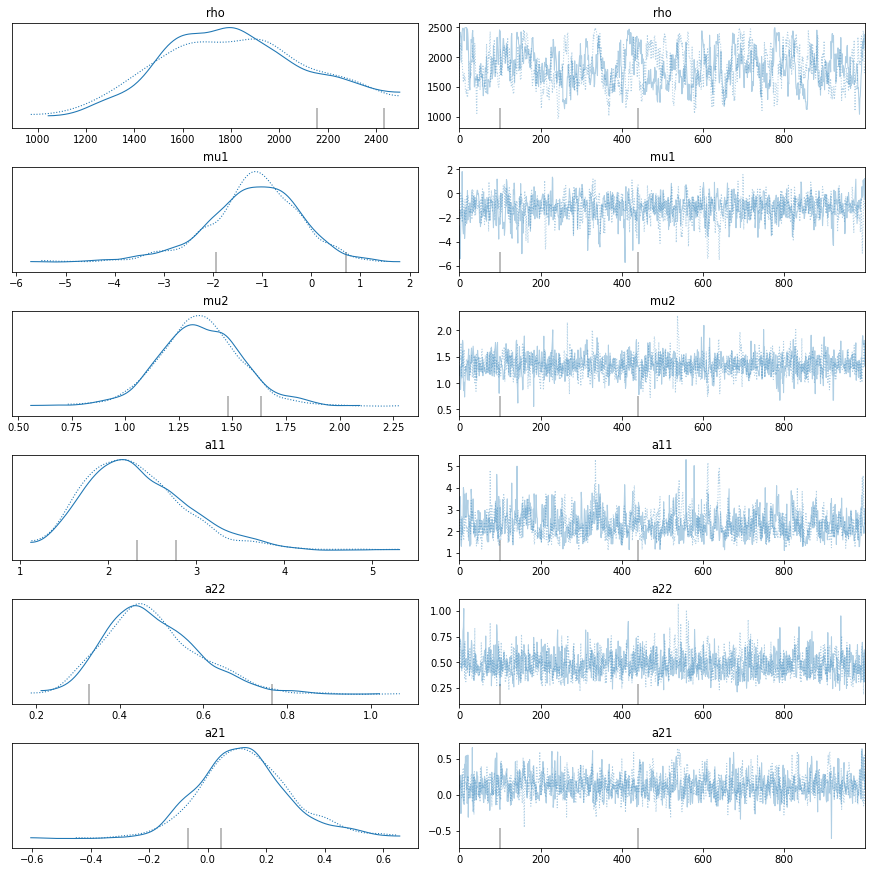

In [12]:
az.plot_trace(trace, var_names=['rho', 'mu1', 'mu2', 'a11', 'a22', 'a21'])
az.summary(trace, var_names=['rho', 'mu1', 'mu2', 'a11', 'a22', 'a21'])

## Check posterior predictive

<AxesSubplot:xlabel='y'>

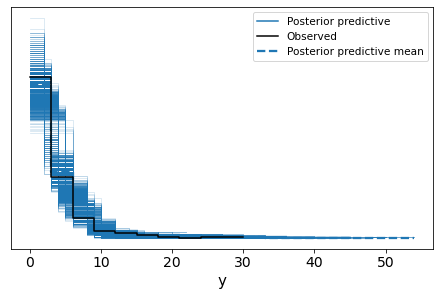

In [13]:
with mlgcp:
    ppc = pm.sample_posterior_predictive(trace)

az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=mlgcp))

## Plot model fit

In [4]:
trace = az.from_netcdf('data/inference_paita.nc')

In [5]:
resolution = 200

# number of cells 
n_cells_x = int(width/resolution)
n_cells_y = int(height/resolution)

# grid location
grid_x = np.linspace(0, width, n_cells_x + 1)
grid_y = np.linspace(0, height, n_cells_y + 1)

# centroid of each cell
centroid_new = np.asarray(list(product(grid_x[:-1] + 0.5*resolution, grid_y[:-1] + 0.5*resolution)))

In [6]:
with mlgcp:
    V1_new = gp1.conditional('V1_new', Xnew=centroid_new)
    V2_new = gp2.conditional('V2_new', Xnew=centroid_new)

    log_intensity1_new = mu1 + a11 * V1_new
    log_intensity2_new = mu2 + a21 * V1_new + a22 * V2_new

    intensity1_new = pm.Deterministic('intensity1_new', pm.math.exp(log_intensity1_new))
    intensity2_new = pm.Deterministic('intensity2_new', pm.math.exp(log_intensity2_new))
    
    trace_new = pm.sample_posterior_predictive(trace, var_names=['intensity1_new', 'intensity2_new'])

In [7]:
foo = pd.DataFrame()
foo['x'] = centroid_new[:,0]
foo['y'] = centroid_new[:,1]
foo['fitted1'] = trace_new['intensity1_new'].mean(axis=0)
foo['fitted2'] = trace_new['intensity2_new'].mean(axis=0)

p1 = ggplot(foo, aes('x', 'y', fill='fitted1')) + geom_tile() + coord_fixed()
p2 = ggplot(foo, aes('x', 'y', fill='fitted2')) + geom_tile() + coord_fixed()

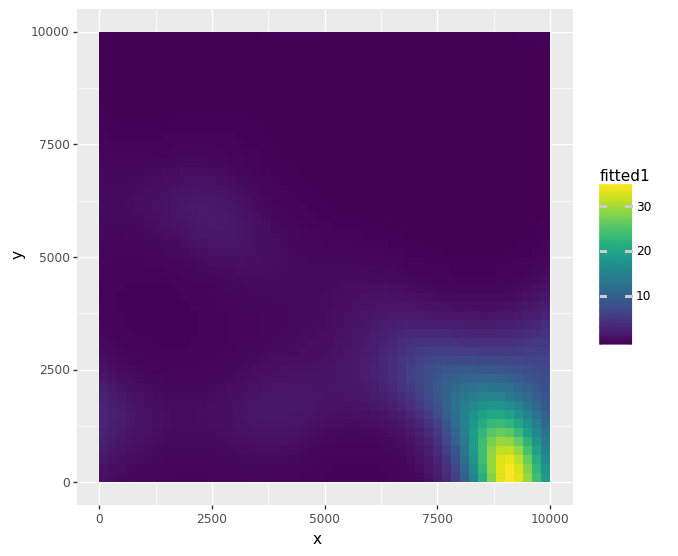

<ggplot: (8774693116233)>

In [8]:
p1

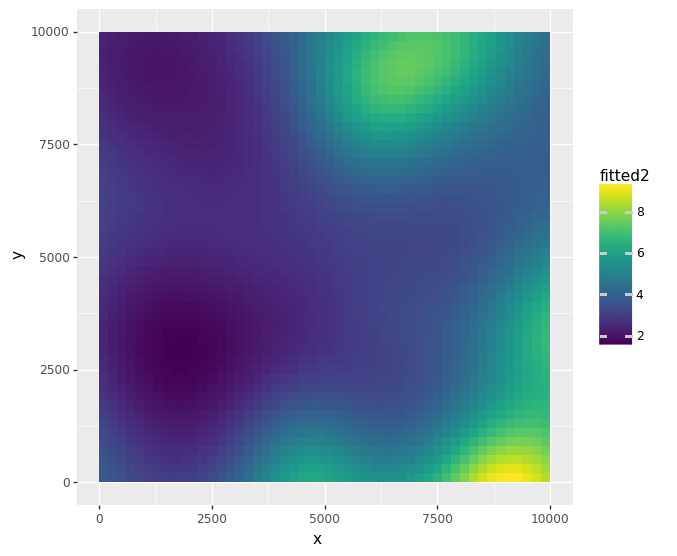

<ggplot: (8774545020254)>

In [9]:
p2

In [ ]:
foo.to_csv('data/pp_paita.csv', index=False)